In [24]:
from pathlib import Path
import os
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd
import moviepy
from moviepy.editor import VideoFileClip, concatenate_videoclips

# There is a conflict between moviepy and the current version of PIL.
# !pip uninstall pillow
# !pip install pillow==9.5.0

import PIL

In [25]:
print(f'Moviepy version: {moviepy.__version__}')
print(f'Pillow version: {PIL.__version__}')

Moviepy version: 1.0.3
Pillow version: 9.5.0


In [26]:
Path.cwd()

WindowsPath('c:/Proyectos/George Brown Projects/2 Semester/Full Stack/AI Travel Video Summarizer/Notebooks')

### Important Paths:

In [27]:
relat_path_vids = Path(r"../Data/Videos") # Relative path where the videos are stored.
relat_path_concats = Path(r"../Data/Concatenated") # Relative path where the concatenated videos are stored.

### Gloval Constants:

In [28]:
FORMATS = [".mp4", ".avi", ".mkv", ".mov"]

# type of video resolution:
LANDSCAPE_RESOLUTION = (1280, 720)
REEL_RESOLUTION = (720, 1280)
TARGET_RESOLUTION = REEL_RESOLUTION # Current working resolution.

# For clip lenght:
MIN_CLIP_LENGTH = 2
MAX_CLIP_LENGTH = 10
MAX_TOTAL_LENGTH = 60

---
# Video Exploration

In [29]:
""" This function checks which videos are available in the videos data folder. """
def available_vids(folder : Path) -> list:
    return [v for v in folder.iterdir() if v.is_file() and v.suffix in FORMATS]

available_vids(relat_path_vids)

[WindowsPath('../Data/Videos/VID_150260111_043842_562.mp4'),
 WindowsPath('../Data/Videos/VID_150260520_164542_331.mp4'),
 WindowsPath('../Data/Videos/VID_150531129_100402_761.mp4'),
 WindowsPath('../Data/Videos/VID_150531201_191623_607.mp4'),
 WindowsPath('../Data/Videos/VID_240631101_150819_887.mp4'),
 WindowsPath('../Data/Videos/VID_34211215_044051_729.mp4'),
 WindowsPath('../Data/Videos/VID_63981014_232039_519.mp4')]

In [30]:
""" This function displays a video in the notebook. """
def display_vid(video_path : Path) -> None:
    display(ipd.Video(video_path, width=600, height=400))
    
display_vid(available_vids(relat_path_vids)[0])

In [31]:
""" This function opens the video in the default video player of the OS. """
def open_vid_default(video_path : Path) -> None:
    os.startfile(video_path)
    
# open_vid_default(available_vids(relat_path_vids)[0])

In [32]:
""" This function displays information about the video. """
def vid_info(video_path : Path) -> None:
    clip = VideoFileClip(str(video_path))
    print(f'Video Name: {video_path.name}')
    print(f"Duration: {clip.duration:.2f} seconds")
    print(f"Frame rate: {clip.fps:.2f} frames per second")
    print(f"Video resolution: {clip.size}")
    clip.close()
    
vid_info(available_vids(relat_path_vids)[0])

Video Name: VID_150260111_043842_562.mp4
Duration: 5.77 seconds
Frame rate: 30.00 frames per second
Video resolution: [480, 854]


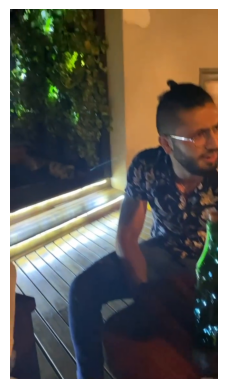

In [33]:
""" This function displays a frame of the video given the time in seconds. """
def display_frames(video_path : Path, time : float) -> None:
    clip = VideoFileClip(str(video_path))
    frame = clip.get_frame(time)
    plt.imshow(frame)
    plt.axis("off")
    clip.close()
    
# NOTE: There is an error with reading the frames of the first video. One of the most 
# common errors. Is a problem of moviepy + ffmpeg.
# Solve in the future by either skiping "corrupted" videos, converting them to clean mp4 
# with FFmped, or reading frames with cv2.
display_frames(available_vids(relat_path_vids)[1], 10)

In [ ]:
""" This function creates and saves a subclip of the video, given a time range. """
def sub_clip(video_path : Path, start_time : float, end_time : float) -> None:
    
    clip = VideoFileClip(str(video_path))
    if end_time > clip.duration:
        end_time = clip.duration
    if start_time < 0 or start_time > clip.duration:
        start_time = 0
    
    print(f'Start time: {start_time}, End time: {end_time}')
    if start_time >= end_time:
        raise ValueError("Start time must be less than end time.")
    
    sub = clip.subclip(start_time, end_time)
    sub.write_videofile("subclip.mp4")
    clip.close()
    sub.close()
    
# sub_clip(available_vids(relat_path_vids)[0], 10, 20)

Moviepy - Building video subclip.mp4.
MoviePy - Writing audio in subclipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video subclip.mp4



Moviepy - Done !
Moviepy - video ready subclip.mp4


In [ ]:
""" This function returns a list of normalized clips. """
def load_and_normalize_vids(folder : Path, resolution : tuple) -> list:
    norm_clips = []
    target_width, target_height = resolution
    
    for vid in available_vids(folder):
        clip = VideoFileClip(str(vid))
        norm = clip.resize(newsize=(target_width, target_height))
        norm_clips.append(norm)
        
    print(f'Normalized clips: {len(norm_clips)}')
    print(f'Duration: {[c.duration for c in norm_clips]}')
        
    return norm_clips

# NOTE: Clips remained open so they can be used in other functions. They should be closed later in the up coming functions. 

norm_clips = load_and_normalize_vids(relat_path_vids, TARGET_RESOLUTION)

Normalized clips: 7
Duration: [5.77, 15.25, 7.51, 9.41, 13.54, 6.63, 4.99]


In [ ]:
""" This function selects the clips that will be concatenated. Cut the long ones, drop the short ones, so the total duration does not exceed the given limit."""
def selected_by_duration(clips : list, max_total_length = MAX_TOTAL_LENGTH, 
                                       min_clip_length = MIN_CLIP_LENGTH, 
                                       max_clip_length = MAX_CLIP_LENGTH) -> list:
    selected = []
    total = 0.0
    
    for clip in clips:
        duration = clip.duration
        
        # Drop short clips:
        if duration < min_clip_length:
            continue
        
        # if it's too long, cut it:
        if duration > max_clip_length:
            cutted = clip.subclip(0, max_clip_length)
            duration = max_clip_length
        else:
            cutted = clip
        
        # If adding a clip exceeds the max total length, cut it:
        if total + duration > max_total_length:
            remaining = max_total_length - total
            
            # If the remaining part is not too short, cut this last video and add it:
            if remaining >= min_clip_length: 
                partial = clip.subclip(0, remaining)
                selected.append(partial)
                total += duration
            break
        else:
            selected.append(cutted)
            total += duration
    print(f'Selected clips: {len(selected)}')
    print(f'Total Duration: {total:.2f} seconds')
    return selected

selected_clips = selected_by_duration(norm_clips)
            

Selected clips: 7
Total Duration: 54.31 seconds


In [ ]:
""" This function concatenates the selected clips and exports the resulting video to a given path. """
def concat_and_export(clips : list, export_path : Path, fps=30) -> None:
    try:
        if len(clips) == 0:
            raise ValueError("No clips selected.")
        
        final_clip = concatenate_videoclips(clips, method="compose")
        final_clip.write_videofile(str(export_path), 
                                fps=fps, 
                                codec="libx264", 
                                audio_codec="aac")
        final_clip.close()
    
    # Here is where the previously opened clips are closed, no matter if an error occurs or not:
    finally:   
        for c in clips:
            c.close()
            
# concat_and_export(selected_clips, relat_path_concats / "concatenated.mp4", fps=30)

Moviepy - Building video ..\Data\Concatenated\concatenated.mp4.
MoviePy - Writing audio in concatenatedTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ..\Data\Concatenated\concatenated.mp4



Moviepy - Done !
Moviepy - video ready ..\Data\Concatenated\concatenated.mp4


In [ ]:
""" This function wraps up the previous functions into one, to get the final result. """
def build_travel_summary(video_folder : Path,
                         export_path : Path,
                         target_resolution = TARGET_RESOLUTION,
                         max_total_length = MAX_TOTAL_LENGTH,
                         min_clip_length = MIN_CLIP_LENGTH,
                         max_clip_length = MAX_CLIP_LENGTH,
                         fps = 30) -> None:
    
    video_paths = available_vids(video_folder)
    if not video_paths:
        raise ValueError("No videos found in the given folder.")
    
    clips = load_and_normalize_vids(video_folder, target_resolution)
    selected = selected_by_duration(clips, max_total_length, min_clip_length, max_clip_length)
    
    concat_and_export(selected, export_path, fps)
    
build_travel_summary(relat_path_vids, relat_path_concats / "summary.mp4")

Selected clips: 7
Total Duration: 54.31 seconds
Moviepy - Building video ..\Data\Concatenated\summary.mp4.
MoviePy - Writing audio in summaryTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ..\Data\Concatenated\summary.mp4



Moviepy - Done !
Moviepy - video ready ..\Data\Concatenated\summary.mp4
